# Fit Thermo Groups From Thermo Library

This script takes in user-specified thermo libraries and automatically identifies missing groups, generates group structures, and calculates missing group values using Ridge regression. It identifies missing group using two criteria:

- If no node matches the structure, it's identified as missing group, and a new group structure is created automatically.
- If a node matches the structure, but it contains `None`, all zeros, or a string as data, it is also identified as missing group.

The original group structure are used. This script generates a `group.py` file and replaces the old one.

In [1]:
from rmgpy import settings
from rmgpy.data.thermo import ThermoDatabase, ThermoData, remove_thermo_data, add_thermo_data
import rmgpy.molecule.group as gr
from rmgpy.molecule.group import Group, GroupAtom, GroupBond
from rmgpy.data.base import Entry
from rmgpy.data.base import LogicOr
from rmgpy.molecule.atomtype import ATOMTYPES

import logging
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from copy import copy, deepcopy
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn-poster")
import numpy as np

from copy import deepcopy
from sklearn.linear_model import RidgeCV,LassoCV,ElasticNetCV,LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load database

In [2]:
libraries = ['Klippenstein_Glarborg2016', 'BurkeH2O2', 'thermo_DFT_CCSDTF12_BAC', 'DFT_QCI_thermo',
                         'primaryThermoLibrary', 'primaryNS', 'NitrogenCurran', 'NOx2018', 'FFCM1(-)',
                         'SulfurLibrary', 'SulfurGlarborgH2S', 'SABIC_aromatics']

In [3]:
database = ThermoDatabase()
database.load(os.path.join(settings['database.directory'],"thermo"),
             libraries = libraries,
             depository=False)

# Helper function

In [310]:
# special_list contains groups that always appear with other groups such that these groups are not independent. 
# For example, O2d-CO always appear with CO-O2d, and S2d-CS always appear with CS-S2d.
# In the past, RMG developers chose to set these groups to be zeros, so we don't generate new groups on them.
# This list needs to be updated when the relevant groups are changed.

special_list = ['O2d-Cdd',
                'O2d-CO',
                'O2d-N5dc',
                'O2d-N3d',
                'O0sc-N5dc',
                'O0sc-N5tc',
                'S2d-CS',
                'S2d-Cdd',
                'S2d-C2d',
                'N1dc-N5ddc',
                'N3t-Ct',
                "Ca",
]

def check_data(label=None,index=None):
    if index is None:
        index = label_index_dict[label]
    
    entry = all_data["entry"][index]
    display(entry.item)
    print(entry.item.smiles)
    entry_thermo = all_data["entry thermo"][index]
    
    print("Entry")
    print(entry.short_desc)
    print(entry.label)
    print(entry_thermo)
    print('')
    print("GAE with estimated GAV")
    print(all_data["GAE with estimated GAV"][index])
    print('')
    print("missing")
    print(all_data["missing groups"][index])
    print('')
    print('GAE without estimated GAV')
    print(all_data["GAE without estimated GAV"][index])
    print('')
    print("GAE with fitted GAV")
    print(all_data["GAE with fitted GAV"][index])
    print('')
    print("New GAE")
    print(all_data["New GAE"][index])
    
def make_group(atom, molecule, use_molecule=False):
    molecule.sort_atoms()
    
    if use_molecule:
        group_atoms = dict()
        for atm in molecule.atoms:
            if atm == atom:
                group_atoms[atm] = gr.GroupAtom(atomtype=[atm.atomtype],
                                                radical_electrons=[atm.radical_electrons],
                                                charge=[atm.charge],
                                                lone_pairs=[atm.lone_pairs],
                                                label="*")
            elif atm.atomtype.label != "H":
                if atm.is_carbon() and atm.lone_pairs == 0 and len([a for a in atm.edges.keys() if a.atomtype.label != "H"])==1 and atm.atomtype.label not in ["CS", "CO", "Ct"]:
                    group_atoms[atm] = gr.GroupAtom(atomtype=[ATOMTYPES["C"]],
                                                    radical_electrons=[atm.radical_electrons],
                                                    label="")
                else:
                    group_atoms[atm] = gr.GroupAtom(atomtype=[atm.atomtype],
                                                    radical_electrons=[atm.radical_electrons],
                                                    label="")
            elif atm.atomtype.label == "H" and atm in atom.edges.keys():
                group_atoms[atm] = gr.GroupAtom(atomtype=[atm.atomtype],
                                                    radical_electrons=[atm.radical_electrons],
                                                    label="")

        group = gr.Group(list(group_atoms.values()))
        
        for atm in molecule.atoms:
            if atm in group_atoms:
                for bonded_atom, bond in atm.edges.items():
                    if bonded_atom in group_atoms:
                        if not group.has_bond(group_atoms[atm],group_atoms[bonded_atom]):
                            group.add_bond(gr.GroupBond(atom1=group_atoms[atm],
                                                        atom2=group_atoms[bonded_atom],
                                                        order=[bond.order]))
                        else:
                            pass
                    
        group.update()
        
        atoms = molecule.get_largest_ring(atom)
        
        in_ring = ''.join(sorted([atom2.atomtype.label for atom2 in atoms
                                                        if atom2.atomtype.label != 'H']))
        
        neighbors = ''.join(sorted([atom2.atomtype.label for atom2 in molecule.atoms
                                                        if atom2.atomtype.label != 'H' and atom2 not in atoms]))
        
        neighbors += 'H' * len(['H' for atom2 in molecule.atoms if atom2.atomtype.label == 'H' and atom2 not in atoms])

        group_str = atom.atomtype.label
        
        if in_ring:
            group_str += f"-ring({in_ring})"

        if neighbors:
            group_str += f'-{neighbors}'
        
        return group, group_str
    
    elif molecule.is_vertex_in_cycle(atom):
        atoms = molecule.get_largest_ring(atom)
        
        group_atoms = dict()
        for atm in atoms + list(atom.edges.keys()):
            if atm not in group_atoms:
                if atm == atom:
                    group_atoms[atm] = gr.GroupAtom(atomtype=[atm.atomtype],
                                                    radical_electrons=[atm.radical_electrons],
                                                    charge=[atm.charge],
                                                    lone_pairs=[atm.lone_pairs],
                                                    label="*")
                else:
                    group_atoms[atm] = gr.GroupAtom(atomtype=[atm.atomtype],
                                                    radical_electrons=[atm.radical_electrons],
                                                    label="")

        group = gr.Group(list(group_atoms.values()))
        for atm in atoms + list(atom.edges.keys()):
            for bonded_atom, bond in atm.edges.items():
                if bonded_atom in group_atoms:
                    if not group.has_bond(group_atoms[atm],group_atoms[bonded_atom]):
                        group.add_bond(gr.GroupBond(atom1=group_atoms[atm],
                                                    atom2=group_atoms[bonded_atom],
                                                    order=[bond.order]))
                    else:
                        pass
                    
        group.update()
        
        in_ring = ''.join(sorted([atom2.atomtype.label for atom2 in atoms
                                            if atom2.atomtype.label != 'H']))
        not_ring = ''.join(sorted([atom2.atomtype.label for atom2 in atom.edges.keys()
                                                        if atom2.atomtype.label != 'H' and atom2 not in atoms]))
        not_ring += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype.label == 'H'])
        
        group_str = atom.atomtype.label
        
        if in_ring:
            group_str += f'-ring({in_ring})'
        
        if not_ring:
            group_str += f'-{not_ring}'
        
        return group, group_str
        
    else:
        group_atoms = {}
        bonds = []

        if atom.atomtype.label in ["O2s", "S2s"]:
            group_atoms[atom] = GroupAtom(atomtype=[atom.atomtype],
                                         radical_electrons=[atom.radical_electrons],
#                                          lone_pairs=[atom.lone_pairs],
#                                          charge=[atom.charge],
                                         label='*')
        else:
            group_atoms[atom] = GroupAtom(atomtype=[atom.atomtype],
                                         radical_electrons=[atom.radical_electrons],
                                         lone_pairs=[atom.lone_pairs],
                                         charge=[atom.charge],
                                         label='*')
        for atm in atom.edges:
            group_atoms[atm] = GroupAtom(atomtype=[atm.atomtype],
                                     radical_electrons=[atm.radical_electrons],
                                     label='')
        group = Group(atoms=list(group_atoms.values()))

        for bonded_atom, bond in atom.edges.items():
            # create a group bond with the same bond order as in the original molecule,
            # if it hasn't already been created
            if not group.has_bond(group_atoms[atom],group_atoms[bonded_atom]):
                group.add_bond(GroupBond(group_atoms[atom],group_atoms[bonded_atom],order=[bond.order]))
            else:
                pass

        group.update()
        
        neighbors = ''.join(sorted([atom2.atomtype.label for atom2 in atom.edges.keys()
                                                        if atom2.atomtype.label != 'H']))
        neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype.label == 'H'])

        group_str = atom.atomtype.label

        if neighbors:
            group_str += f'-{neighbors}'

        return group, group_str
    
def add_thermo_data_unc(thermo_data1, thermo_data2, group_additivity=True, verbose=False):
    """
    Add the thermodynamic data `thermo_data2` to the data `thermo_data1`,
    and return `thermo_data1`.

    If `group_additivity` is True, append comments related to group additivity estimation
    If `verbose` is False, omit the comments from a "zero entry", whose H298, S298, and Cp are all 0.
    If `verbose` is True, or thermo_data2 is not a zero entry, add thermo_data2.comment to thermo_data1.comment.
    """
    if (len(thermo_data1.Tdata.value_si) != len(thermo_data2.Tdata.value_si) or
            any([T1 != T2 for T1, T2 in zip(thermo_data1.Tdata.value_si, thermo_data2.Tdata.value_si)])):
        raise ValueError('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermo_data1.Tdata.value_si.shape[0]):
        thermo_data1.Cpdata.value_si[i] += thermo_data2.Cpdata.value_si[i]
        thermo_data1.Cpdata.uncertainty_si[i] += thermo_data2.Cpdata.uncertainty_si[i]
    thermo_data1.H298.value_si += thermo_data2.H298.value_si
    thermo_data1.H298.uncertainty_si += thermo_data2.H298.uncertainty_si
    thermo_data1.S298.value_si += thermo_data2.S298.value_si
    thermo_data1.S298.uncertainty_si += thermo_data2.S298.uncertainty_si

    test_zero = sum(abs(value) for value in
                    [thermo_data2.H298.value_si, thermo_data2.S298.value_si] + thermo_data2.Cpdata.value_si.tolist())
    # Used to check if all of the entries in thermo_data2 are zero

    if group_additivity:
        if verbose or test_zero != 0:
            # If verbose==True or test_zero!=0, add thermo_data2.comment to thermo_data1.comment.
            if thermo_data1.comment:
                thermo_data1.comment += ' + {0}'.format(thermo_data2.comment)
            else:
                thermo_data1.comment = 'Thermo group additivity estimation: ' + thermo_data2.comment

    return thermo_data1

# Get entry data from thermo libraries, identify missing groups, generate group structure for missing groups, obtain current GA estimation

In [311]:
all_data = dict()
all_data["entry"] = list()
all_data["entry thermo"] = list()
all_data["GAE without estimated GAV"] = list()
all_data["GAE with estimated GAV"] = list()
all_data["missing GAE"] = list()
all_data["missing groups"] = list()

missing_group_index_dict = dict()
missing_group_dict = dict()
missing_group_index = 0

# special_group_dict = dict()

for library in database.libraries:
    
    entries=list(database.libraries[library].entries.items())
    
    for item, entry in entries:
        
        if entry.data is not None:
            
            if not isinstance(entry.data, ThermoData):
                try:
                    entry_thermo = entry.data.to_thermo_data()
                except:
                    continue
            else:
                entry_thermo = entry.data

            molecule = entry.item
            
            if "C" not in molecule.smiles or molecule.smiles=="[Cl][Cl]" or molecule.smiles=="Cl" or entry.label=="CHCH3(S)":
                    continue

            if not molecule.is_radical():
                missing_grp = list()
                missing = 0

                thermo_data = ThermoData(
                        Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                        Cpdata=([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "J/(mol*K)"),
                        H298=(0.0, "kJ/mol"),
                        S298=(0.0, "J/(mol*K)"),
                    )

                molecule.sort_atoms()
                
                for atom in molecule.atoms:

                    if atom.is_non_hydrogen():

                        node0 = database.groups['group'].descend_tree(molecule, {'*': atom}, None)

                        node = node0

                        data = node.data

                        add = False
                        if data is None or isinstance(data,str) or data.is_all_zeros():

#                             neighbors = ''.join(sorted([atom2.atomtype.label for atom2 in atom.edges.keys()
#                                                         if atom2.atomtype.label != 'H']))
#                             neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype.label == 'H'])
                            
#                             group_str = atom.atomtype.label

#                             if neighbors:
#                                 group_str += f'-{neighbors}'
                               
                            group, group_str = make_group(atom, molecule)
                            group.sort_atoms()
                            
#                             if molecule.is_vertex_in_cycle(atom):
#                                 group_str = make_group_label('', group.get_labeled_atoms("*")[0], len(group.atoms), {})
                                
                            group_str = f'{node.label}_{group_str}'
                    
#                             if group_str.split("_")[-1] in special_list and group_str.split("_")[-1] not in special_group_dict:
#                                 special_group_dict[group_str] = dict()
#                                 special_group_dict[group_str]["group"] = group
#                                 special_group_dict[group_str]["atom"] = atom
#                                 special_group_dict[group_str]["molecule"] = molecule
                            
                            if group_str.split("_")[-1] not in special_list:
                                missing += 1
                                missing_grp.append(group_str)
                                if group_str not in missing_group_index_dict:
                                    missing_group_index_dict[group_str] = missing_group_index
                                    missing_group_index+=1
                                    
                                    missing_group_dict[group_str] = dict()
                                    missing_group_dict[group_str]["group"] = [group]
                                    missing_group_dict[group_str]["atom"] = [atom]
                                    missing_group_dict[group_str]["molecule"] = [molecule]
                                    missing_group_dict[group_str]["label"] = [entry.label]
                                else:
                                    missing_group_dict[group_str]["group"].append(group)
                                    missing_group_dict[group_str]["atom"].append(atom)
                                    missing_group_dict[group_str]["molecule"].append(molecule)
                                    missing_group_dict[group_str]["label"].append(entry.label)
                            else:
                                add = True
                        else:
                            add = True
                            
                        if add:
                            while node is not None and node.data is None:
                                node = node.parent
                            if node is None:
                                raise DatabaseError(f'Unable to determine thermo parameters for atom {atom} in molecule {molecule}: '
                                                    f'no data for node {node0} or any of its ancestors in database {database.label}.')

                            data = node.data
                            comment = node.label
                            loop_count = 0
                            while isinstance(data, str):
                                loop_count += 1
                                if loop_count > 100:
                                    raise DatabaseError("Maximum iterations reached while following thermo group data pointers. A circular"
                                                        f" reference may exist. Last node was {node.label} pointing to group called {data} in "
                                                        f"database {database.label}")

                                for entr in database.groups["group"].entries.values():
                                    if entr.label == data:
                                        data = entr.data
                                        comment = entr.label
                                        break
                                else:
                                    raise DatabaseError(f"Node {node.label} points to a non-existing group called {data} "
                                                        f"in database {database.label}")

                            data.comment = '{0}({1})'.format(database.groups['group'].label, comment)
                            add_thermo_data(thermo_data, data, group_additivity=True)
                    
                cyclic = molecule.is_cyclic()

                if cyclic:
                    sssr = molecule.get_smallest_set_of_smallest_rings()
                    for ring in sssr:
                        for atomPair in itertools.permutations(ring, 2):
                            try:
                                database._add_group_thermo_data(thermo_data, database.groups['longDistanceInteraction_cyclic'], molecule,
                                                            {'*1': atomPair[0], '*2': atomPair[1]})
                            except KeyError:
                                pass

                # Do ring corrections separately because we only want to match
                # each ring one time

                if cyclic:
                    monorings, polyrings = molecule.get_disparate_cycles()
                    for ring in monorings:
                        # Make a temporary structure containing only the atoms in the ring
                        # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
                        try:
                            database._add_ring_correction_thermo_data_from_tree(thermo_data, database.groups['ring'], molecule, ring)
                        except KeyError:
                            logging.error("Couldn't find a match in the monocyclic ring database even though "
                                          "monocyclic rings were found.")
                            logging.error(molecule)
                            logging.error(molecule.to_adjacency_list())
                            raise
                    for polyring in polyrings:
                        # Make a temporary structure containing only the atoms in the ring
                        # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
                        try:
                            database._add_polycyclic_correction_thermo_data(thermo_data, molecule, polyring)
                        except KeyError:
                            logging.error("Couldn't find a match in the polycyclic ring database even though "
                                          "polycyclic rings were found.")
                            logging.error(molecule)
                            logging.error(molecule.to_adjacency_list())
                        
                if missing > 0:
                    entry.short_desc = library
                    all_data["entry"].append(entry)
                    all_data["GAE without estimated GAV"].append(thermo_data)
                    estimated_thermo = database.estimate_thermo_via_group_additivity(molecule)
                    all_data["GAE with estimated GAV"].append(estimated_thermo)
                    all_data["missing groups"].append(missing_grp)
                    all_data["entry thermo"].append(entry_thermo)

                    try:
                        missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo),thermo_data)
                        all_data["missing GAE"].append(missing_group_thermo)
                    except (ValueError,IndexError):
                        if entry_thermo.Cp0 is None:
                            cp_0 = molecule.calculate_cp0()
                            entry_thermo.Cp0 = (cp_0, "J/(mol*K)")
                        if entry_thermo.CpInf is None:
                            cp_inf = molecule.calculate_cpinf()
                            entry_thermo.CpInf = (cp_inf, "J/(mol*K)")

                        nasa = entry_thermo.to_nasa(Tmin=10.0, Tmax=3000.0, Tint=500.0)
                        entry_thermo = nasa.to_thermo_data()
                        missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo),thermo_data)
                        all_data["missing GAE"].append(missing_group_thermo)
                    


In [312]:
spc_num = len(all_data["entry"])
grp_num = len(missing_group_index_dict.keys())

In [313]:
spc_num

79

In [314]:
grp_num

57

# Construct A and b, do the fitting, calculate uncertainty

In [315]:
A = np.zeros((spc_num,grp_num))
b = np.zeros((spc_num,9))

In [316]:
label_index_dict=dict()
for spc_index, entry in enumerate(all_data["entry"]):
    label_index_dict[entry.label]=spc_index
    groups = all_data["missing groups"][spc_index]
    for group in groups:
        A[spc_index, missing_group_index_dict[group]]+=1
    
    thermo_data = all_data["missing GAE"][spc_index]
    b[spc_index,0] = thermo_data.H298.value_si
    b[spc_index,1] = thermo_data.S298.value_si
    b[spc_index,2:9] = thermo_data.Cpdata.value_si

In [317]:
soln_dict = dict()
alpha = 0.01
soln = Ridge(alpha=alpha,fit_intercept=False,normalize=False, max_iter=1e5).fit(A,b)
soln_dict["Ridge"]=soln
# soln = Lasso(alpha=alpha,fit_intercept=False,normalize=False, max_iter=1e5).fit(A,b)
# soln_dict["Lasso"]=soln
# soln = RidgeCV(alphas=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],fit_intercept=False,normalize=False).fit(A,b)
# soln_dict["RidgeCV"]=soln
# alpha = soln_dict["RidgeCV"].alpha_

# Look at parity plot for training error and uncertainty from fitting

In [318]:
b_pred = soln_dict["Ridge"].predict(A)

standard_error = dict()
for i in range(b.shape[1]):
    residuals = b[:,i] - b_pred[:,i]
    sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
    var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])))
    standard_error[i] = np.diagonal(var_beta_hat)**0.5

# Write the fitted data to ThermoData format

In [319]:
fitted_group_data = dict()

for i, label in enumerate(missing_group_index_dict.keys()):
    x = soln_dict["Ridge"].coef_.T
    H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
    H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,9)]
    fitted_group_data[label] = ThermoData(
            Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
            Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
            H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
            S298=(S298, "J/(mol*K)", "+|-", S298_unc),
            comment=f"fitted({label})",
        )

# Calculate GA estimation using new fitted groups

In [320]:
all_data["GAE with fitted GAV"]=list()

for spc_index, groups in enumerate(all_data["missing groups"]):
    
    GAE_without_estimated_GA = all_data["GAE without estimated GAV"][spc_index]
    
    fitted_thermo = deepcopy(GAE_without_estimated_GA)
    for group in groups:
        add_thermo_data_unc(fitted_thermo,fitted_group_data[group])
        
    all_data["GAE with fitted GAV"].append(fitted_thermo)


Text(0.5, 1.0, 'RMSE: 0.9, MAE: 0.4 kcal/mol')

<Figure size 720x720 with 0 Axes>

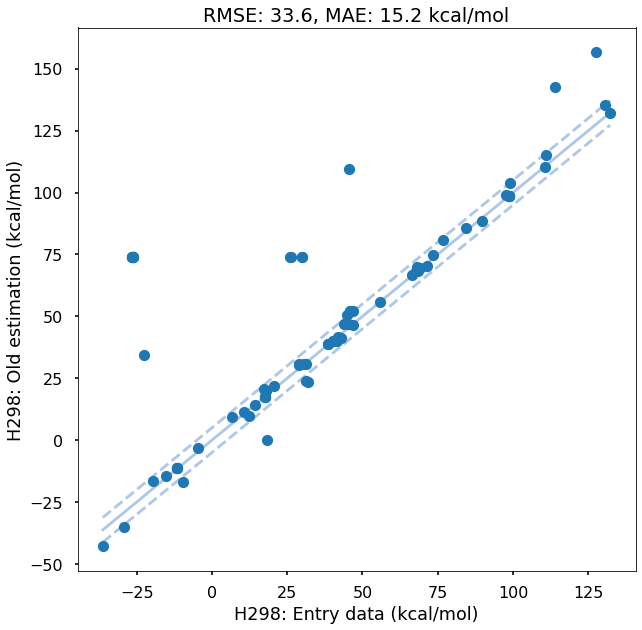

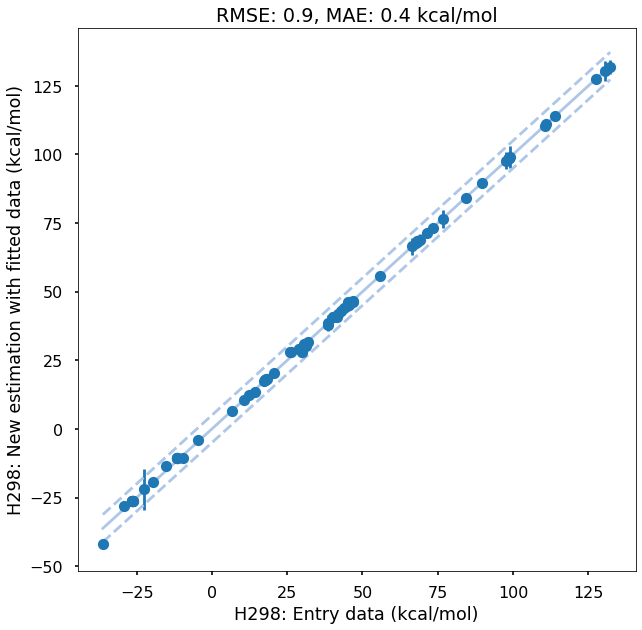

In [321]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.H298.value_si/4180)
    new_GAE_uncertainties.append(fitted_GAE.H298.uncertainty_si/4180)
    
    
plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: Old estimation (kcal/mol)")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>15:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation with fitted data (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

# plt.figure()
# plt.hist(np.array(entry_values)-np.array(new_GAE_values),alpha=0.5,label="New GA estimation")
# plt.hist(np.array(entry_values)-np.array(old_GAE_values),alpha=0.5,label="Old GA estimation")
# plt.xlabel("H298 error (kcal/mol)")
# plt.ylabel("Counts (-)")
# plt.legend()

Text(0.5, 1.0, 'RMSE: 0.8, MAE: 0.5 cal/(mol*K)')

<Figure size 720x720 with 0 Axes>

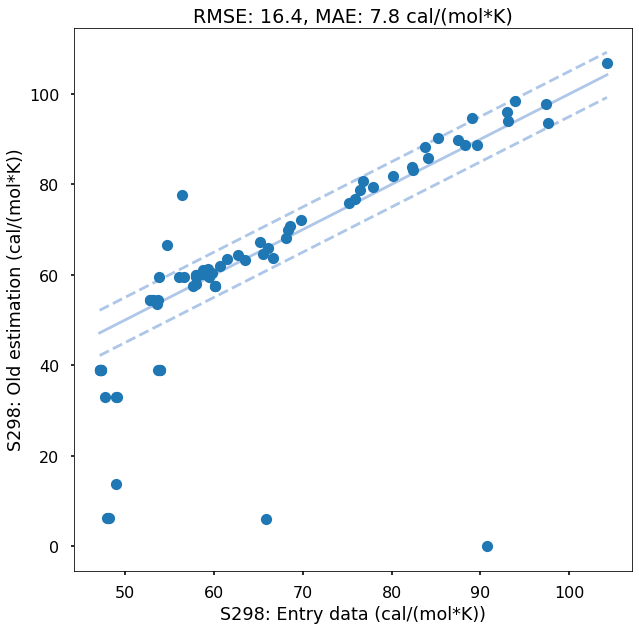

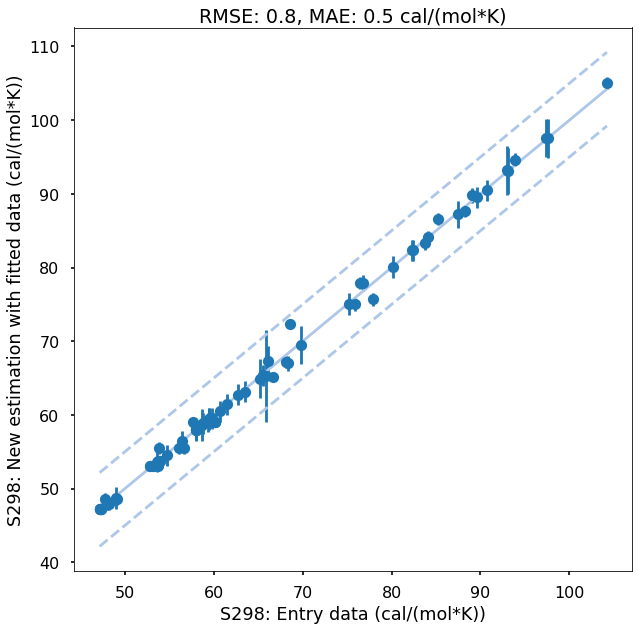

In [322]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()


for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.S298.value_si/4.180)
    new_GAE_uncertainties.append(fitted_GAE.S298.uncertainty_si/4.180)

plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: Old estimation (cal/(mol*K))")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>5:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation with fitted data (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

# plt.figure()
# plt.hist(np.array(entry_values)-np.array(new_GAE_values),alpha=0.5,label="New GA estimation")
# plt.hist(np.array(entry_values)-np.array(old_GAE_values),alpha=0.5,label="Old GA estimation")
# plt.xlabel("S298 error (cal/mol-K)")
# plt.ylabel("Counts (-)")
# plt.legend()

# Check if there's bad fit

In [323]:
bad_fit_list = list()
n=5
for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_thermo = all_data["entry thermo"][spc_index]
    diff = abs(entry_thermo.H298.value_si-all_data["GAE with estimated GAV"][spc_index].H298.value_si)
    diff_new = abs(entry_thermo.H298.value_si-all_data["GAE with fitted GAV"][spc_index].H298.value_si)
    if diff<diff_new:
        bad_fit_list.extend(all_data["missing groups"][spc_index])
    if diff_new>n*4.18*1000:
        bad_fit_list.extend(all_data["missing groups"][spc_index])
    diff = abs(entry_thermo.S298.value_si-all_data["GAE with estimated GAV"][spc_index].S298.value_si)
    diff_new = abs(entry_thermo.S298.value_si-all_data["GAE with fitted GAV"][spc_index].S298.value_si)
    if diff<diff_new:
        bad_fit_list.extend(all_data["missing groups"][spc_index])
    if diff_new>n*4.18:
        bad_fit_list.extend(all_data["missing groups"][spc_index])
        
temp = list()
for grp_label in bad_fit_list:
    entry_label = grp_label.split("_")[-1]
    if entry_label not in temp and entry_label not in special_list:
        temp.append(entry_label)
temp

['Cdd-CdO2d',
 'Cd-C2dHH',
 'Ct-N3tH',
 'Cdd-C2dO2d',
 'Cd-CddHH',
 'Cdd-C2dCd',
 'Cdd-CddO2d',
 'N5tc-CtO0sc',
 'Cs-CdHHH',
 'Cs-CdS2sHH',
 'Ct-CSCt',
 'CS-CdCsS2d']

# Write fitted data to database

In [324]:
database_new = deepcopy(database)
duplicate = dict()
group_changed = dict()
missing_group_dict_new = dict()

for group_str in missing_group_dict.keys():
    group = missing_group_dict[group_str]["group"][0]
    group_atom = missing_group_dict[group_str]["atom"][0]
    molecule = missing_group_dict[group_str]["molecule"][0]
    entry_label = group_str.split("_")[-1]
    
    if entry_label in database_new.groups['group'].entries:
        entry_data = database_new.groups['group'].entries[entry_label].data
        if entry_data is not None and not isinstance(entry_data,str):
            if not database_new.groups['group'].entries[entry_label].data.is_all_zeros():
                counter = 0
                while entry_label in database_new.groups['group'].entries:
                    print(entry_label)
                    if entry_label not in duplicate:
                        duplicate[entry_label] = dict()
                        duplicate[entry_label]["group"] = group
                        duplicate[entry_label]["atom"] = group_atom
                        duplicate[entry_label]["molecule"] = molecule
                    counter += 1
                    entry_label = entry_label.split('_')[0]
                    entry_label += '_{0}'.format(counter)
                    if entry_label not in duplicate:
                        duplicate[entry_label] = dict()
                        duplicate[entry_label]["group"] = group
                        duplicate[entry_label]["atom"] = group_atom
                        duplicate[entry_label]["molecule"] = molecule

    string = ''
    for ind in np.nonzero(A[:,missing_group_index_dict[group_str]])[0]:
        string += f'{all_data["entry"][ind].item.smiles} ({all_data["entry"][ind].label}) from {all_data["entry"][ind].short_desc}\n'
        
    node0 = database_new.groups['group'].descend_tree(molecule, {'*': group_atom}, None)
    
    # make L3 dummy node
    if node0.label in ["C", "O", "N", "S"]:
        entry = Entry(index = len(database_new.groups['group'].entries)+1,
                        label = group_atom.atomtype.label,
                        item = Group().from_adjacency_list(f"""1 * {group_atom.atomtype.label} u0"""),
                        data = None,
                        short_desc = """Dummy L3 group added by Hao-Wei Pang""",
                        long_desc = f"""Dummy L3 group added by Hao-Wei Pang during fitting groups from thermo libraries""",
                        parent = node0)
        database_new.groups["group"].entries[group_atom.atomtype.label] = entry
        database_new.groups["group"].entries[node0.label].children.append(entry)
        node0 = database_new.groups["group"].entries[group_atom.atomtype.label]
#         missing_group_dict[f"{node0.label}_{entry_label}"] = missing_group_dict[group_str]
        
        
        
    replace = False
    reason = ''
    if node0.data is None:
        reason = "None"
    elif isinstance(node0.data,str):
        reason = node0.data
    elif node0.data.is_all_zeros():
        reason = "all zeros"
        
    if reason:
        if node0.item.is_isomorphic(group):
            
            for atom in node0.item.atoms:
                if atom.label:
                    neighbors = ''.join(sorted([atom2.atomtype[0].label for atom2 in atom.edges.keys()
                                                if atom2.atomtype[0].label != 'H']))
                    neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype[0].label == 'H'])

                    node0_group_str = atom.atomtype[0].label

                    if neighbors:
                        node0_group_str += f'-{neighbors}'

                    if node0_group_str == entry_label:
                        replace = True
                        
        if len(node0.item.atoms) > len(group.atoms):
            replace = True
            
        
    missing_group_dict[group_str]["node0"] = node0
    missing_group_dict_new[f"{node0.label}_{entry_label}"]=missing_group_dict[group_str]
    
    if replace:
        database_new.groups['group'].entries[node0.label].data = fitted_group_data[group_str]
        database_new.groups['group'].entries[node0.label].short_desc = """Fitted from RMG thermo libraries by Hao-Wei Pang"""
        database_new.groups['group'].entries[node0.label].long_desc = f"""Previously contains {reason} as data. New data fitted from following species using Ridge regression

{string}

"""

        missing_group_dict[group_str]["entry"] = database_new.groups['group'].entries[node0.label]
        missing_group_dict[group_str]["replaced"] = True
    else:
        entry = Entry(index = len(database_new.groups['group'].entries)+1,
                        label = entry_label,
                        item = group,
                        data = fitted_group_data[group_str],
                        short_desc = """Group added & fitted from RMG thermo libraries by Hao-Wei Pang""",
                        long_desc = f"""Fitted from following species using Ridge regression

{string}

    """,
                         parent = node0)
        
        missing_group_dict[group_str]["entry"] = entry
        missing_group_dict[group_str]["replaced"] = False
        database_new.groups['group'].entries[entry_label] = entry
        database_new.groups["group"].entries[node0.label].children.append(entry)
        
        try:
            sample_molecule = entry.item.make_sample_molecule()
        except:
            logging.error("Problem making sample molecule for group {}\n{}".format(
                entryName, entry.item.to_adjacency_list()))
            raise
        # for now ignore sample atoms that use nitrogen types
        nitrogen = False
        for atm in sample_molecule.atoms:
            if atm.is_nitrogen():
                nitrogen = True

        if not nitrogen:
            atoms = sample_molecule.get_all_labeled_atoms()
            match = database.groups["group"].descend_tree(sample_molecule, atoms, strict=True)

            if entry not in [match] + database_new.groups["group"].ancestors(match):
                molecule = missing_group_dict[group_str]["molecule"][0]
                grp, grp_str = make_group(group_atom, molecule, use_molecule=True)
                database_new.groups["group"].entries[entry.label].item = grp
                group_changed[entry.label] = (grp, grp_str, node0)
                
        if not database.groups["group"].match_node_to_child(node0, entry):
            molecule = missing_group_dict[group_str]["molecule"][0]
            grp, grp_str = make_group(group_atom, molecule, use_molecule=True)
            database_new.groups["group"].entries[entry.label].item = grp
            group_changed[entry.label] = (grp, grp_str, node0)
            
for old_str, pair in group_changed.items():
    grp, grp_str, node0 = pair
    entry = database_new.groups["group"].entries[old_str]
    database_new.groups["group"].remove_group(entry)
    entry.label = grp_str
    counter = 0
    while entry.label in database_new.groups['group'].entries:
        counter += 1
        entry.label += '_{0}'.format(counter)
    database_new.groups["group"].entries[entry.label] = entry
    database_new.groups["group"].entries[node0.label].children.append(entry)



N3d-CdCs
Cd-ring(COCdCdCdCdCdd)-H
Cd-ring(COCdCdCdCdCdd)-H
Cd-ring(COCdCdCdCdCdd)-H_1


# Check that we land on the right node when using group additivity

In [325]:
all_data["New GAE"] = list()
for entry in all_data["entry"]:
    molecule = entry.item
    all_data["New GAE"].append(database_new.estimate_thermo_via_group_additivity(molecule))

Text(0.5, 1.0, 'RMSE: 0.9, MAE: 0.4 kcal/mol')

<Figure size 720x720 with 0 Axes>

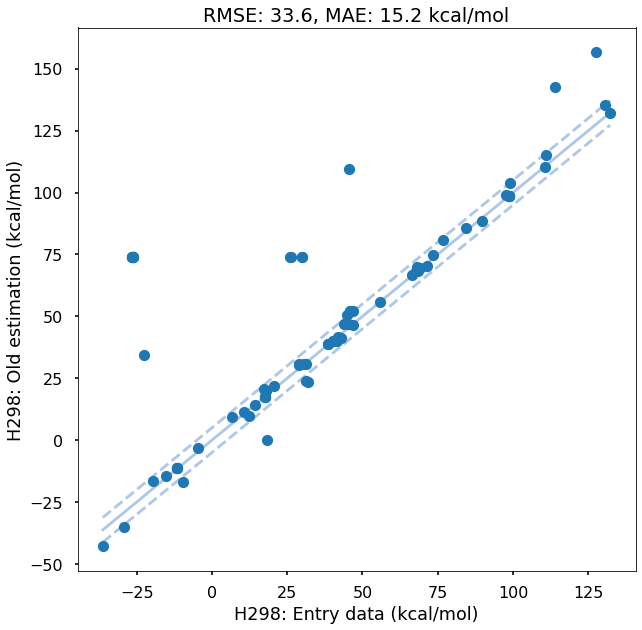

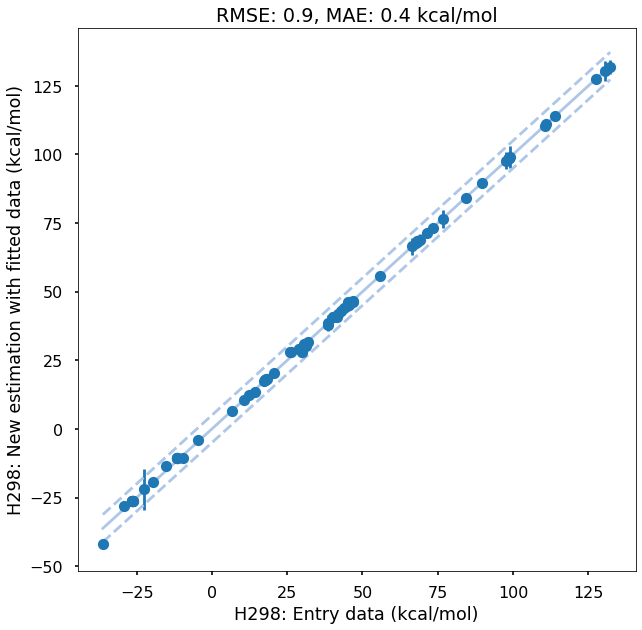

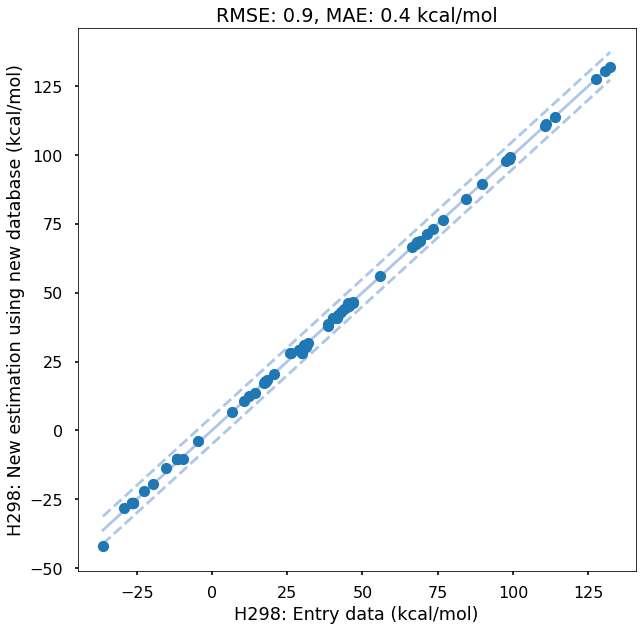

In [326]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.H298.value_si/4180)
    new_GAE_uncertainties.append(fitted_GAE.H298.uncertainty_si/4180)
    new_new_GAE_values.append(all_data["New GAE"][spc_index].H298.value_si/4180)
    
    
plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: Old estimation (kcal/mol)")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>15:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation with fitted data (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_new_GAE_values,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_new_GAE_values[i])>15:
        plt.text(entry_value, new_new_GAE_values[i], s=str(i)+all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation using new database (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

# plt.figure()
# plt.hist(np.array(entry_values)-np.array(new_GAE_values),alpha=0.5,label="New GA estimation")
# plt.hist(np.array(entry_values)-np.array(old_GAE_values),alpha=0.5,label="Old GA estimation")
# plt.xlabel("H298 error (kcal/mol)")
# plt.ylabel("Counts (-)")
# plt.legend()

Text(0.5, 1.0, 'RMSE: 0.8, MAE: 0.5 cal/(mol*K)')

<Figure size 720x720 with 0 Axes>

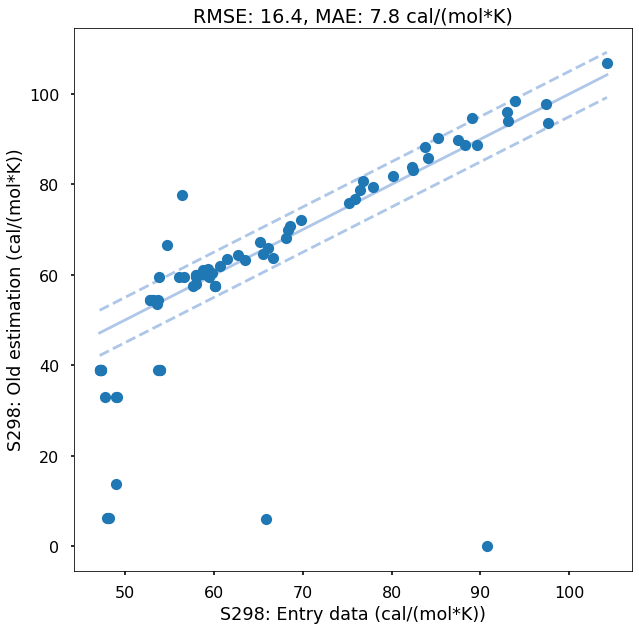

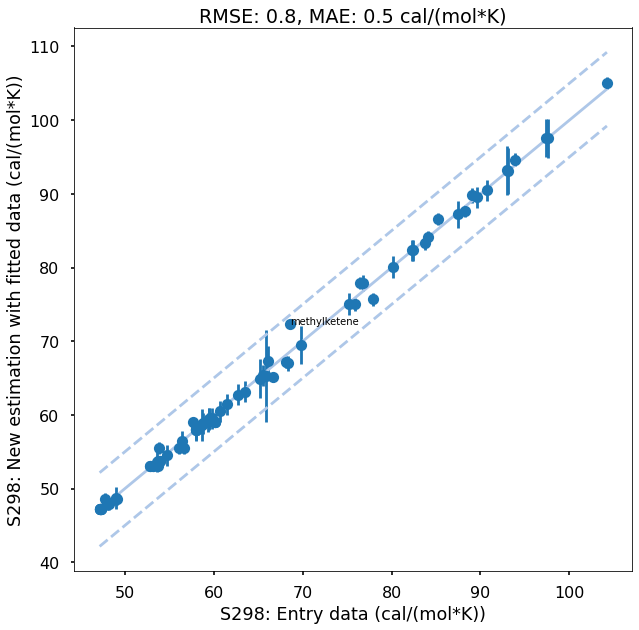

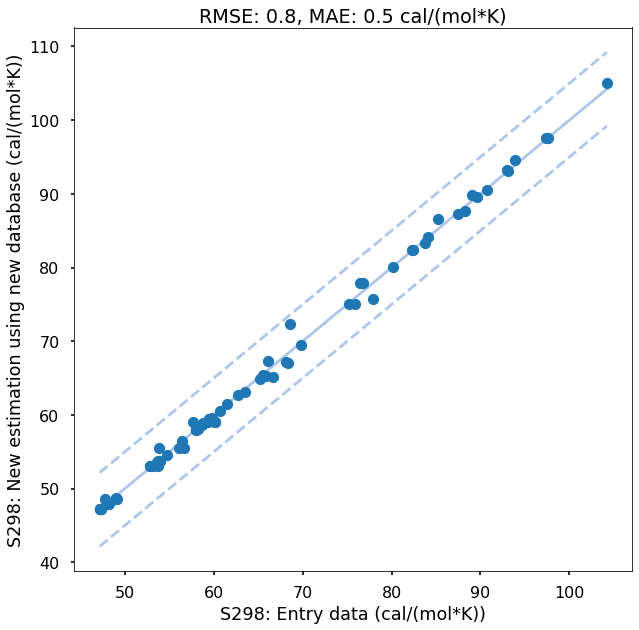

In [327]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()


for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.S298.value_si/4.180)
    new_GAE_uncertainties.append(fitted_GAE.S298.uncertainty_si/4.180)
    new_new_GAE_values.append(all_data["New GAE"][spc_index].S298.value_si/4.180)

plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: Old estimation (cal/(mol*K))")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>3:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation with fitted data (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_new_GAE_values,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_new_GAE_values[i])>5:
        plt.text(entry_value, new_new_GAE_values[i], s=str(i)+all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation using new database (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

# plt.figure()
# plt.hist(np.array(entry_values)-np.array(new_GAE_values),alpha=0.5,label="New GA estimation")
# plt.hist(np.array(entry_values)-np.array(old_GAE_values),alpha=0.5,label="Old GA estimation")
# plt.xlabel("S298 error (cal/mol-K)")
# plt.ylabel("Counts (-)")
# plt.legend()

In [335]:
# check_data(index=29)

# Make sure we pass database test

In [329]:
group_name = "group"
group = database.groups["group"]

entries_copy = copy(group.entries)
tst = []
for node_name, node_group in group.entries.items():
    del entries_copy[node_name]
    for node_name_other, node_group_other in entries_copy.items():
        group.match_node_to_node(node_group, node_group_other)
        tst.append((group.match_node_to_node(node_group, node_group_other),
                    "Node {node} in {group} group was found to be identical to node {node_other}".format(
                        node=node_name, group=group_name, node_other=node_name_other)))

boo = False
for i in range(len(tst)):
    if tst[i][0]:
        logging.error(tst[i][1])
        boo = True

if boo:
    raise ValueError("Error Occurred")
    
    

In [330]:
tst1 = []
tst2 = []
for node_name, child_node in group.entries.items():
    # top nodes and product nodes don't have parents by definition, so they get an automatic pass:
    if child_node in group.top:
        continue
    parent_node = child_node.parent
    # Check whether the node has proper parents unless it is the top reactant or product node
    # The parent should be more general than the child
    tst1.append((group.match_node_to_child(parent_node, child_node),
                 "In {group} group, node {parent} is not a proper parent of its child {child}.".format(
                     group=group_name, parent=parent_node, child=node_name)))

    # check that parentNodes which are LogicOr do not have an ancestor that is a Group
    # If it does, then the child_node must also be a child of the ancestor
    if isinstance(parent_node.item, LogicOr):
        ancestor_node = parent_node
        while ancestor_node not in group.top and isinstance(ancestor_node.item, LogicOr):
            ancestor_node = ancestor_node.parent
        if isinstance(ancestor_node.item, Group) and tst1[-1][0]:
            tst2.append((group.match_node_to_child(ancestor_node, child_node),
                         "In {group} group, node {ancestor} is not a proper ancestor of its child {child}."
                         "".format(group=group_name, ancestor=ancestor_node, child=node_name)))

boo = False
for i in range(len(tst1)):
    if not tst1[i][0]:
        logging.error(tst1[i][1])
        boo = True
for i in range(len(tst2)):
    if not tst2[i][0]:
        logging.error(tst2[i][1])
        boo = True

if boo:
    raise ValueError("Error Occurred")

# 1-fold validation

In [331]:
RMSEs = list()
MAEs = list()

# alphas = [1, 0.1, 1e-2, 1e-4, 1e-6, 1e-8]
alphas = [1e-5,1e-4,1e-3, 1e-2, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 1e-1, 1]
for alpha in alphas:
    all_data["cross validation estimation"]=list()
    for skip_spc_index in range(spc_num):

        A = np.zeros((spc_num,grp_num))
        b = np.zeros((spc_num,9))

        for spc_index, entry in enumerate(all_data["entry"]):
            if spc_index == skip_spc_index:
                pass
            else:
                groups = all_data["missing groups"][spc_index]
                for group in groups:
                    A[spc_index, missing_group_index_dict[group]]+=1

                thermo_data = all_data["missing GAE"][spc_index]
                b[spc_index,0] = thermo_data.H298.value_si
                b[spc_index,1] = thermo_data.S298.value_si
                b[spc_index,2:9] = thermo_data.Cpdata.value_si

        soln = Ridge(alpha=alpha,fit_intercept=False,normalize=False, max_iter=1e5).fit(A,b)
        soln_dict["Ridge"]=soln

        b_pred = soln_dict["Ridge"].predict(A)

        standard_error = dict()
        for i in range(b.shape[1]):
            residuals = b[:,i] - b_pred[:,i]
            sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
            var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])))
            standard_error[i] = np.diagonal(var_beta_hat)**0.5

        fitted_group_data = dict()

        for i, label in enumerate(missing_group_index_dict.keys()):
            x = soln_dict["Ridge"].coef_.T
            H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
            H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,9)]
            fitted_group_data[label] = ThermoData(
                    Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                    Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
                    H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
                    S298=(S298, "J/(mol*K)", "+|-", S298_unc),
                    comment=f"fitted({label})",
                )

        groups = all_data["missing groups"][skip_spc_index]

        GAE_without_estimated_GA = all_data["GAE without estimated GAV"][skip_spc_index]

        fitted_thermo = deepcopy(GAE_without_estimated_GA)
        for group in groups:
            add_thermo_data_unc(fitted_thermo,fitted_group_data[group])

        all_data["cross validation estimation"].append(fitted_thermo)
        
    entry_values = list()
    cross_validation_values = list()
    for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
        entry_values.append(entry_thermo.H298.value_si/4180)
        cross_validation_GAE = all_data["cross validation estimation"][spc_index]
        cross_validation_values.append(cross_validation_GAE.H298.value_si/4180)
        
    RMSE = mean_squared_error(entry_values,cross_validation_values,squared=False)
    MAE = mean_absolute_error(entry_values,cross_validation_values)
    RMSEs.append(RMSE)
    MAEs.append(MAE)


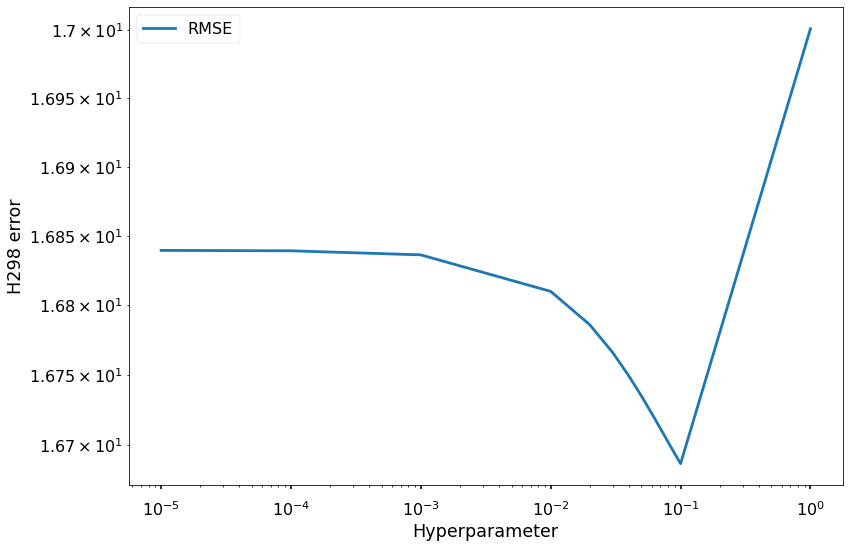

0.02


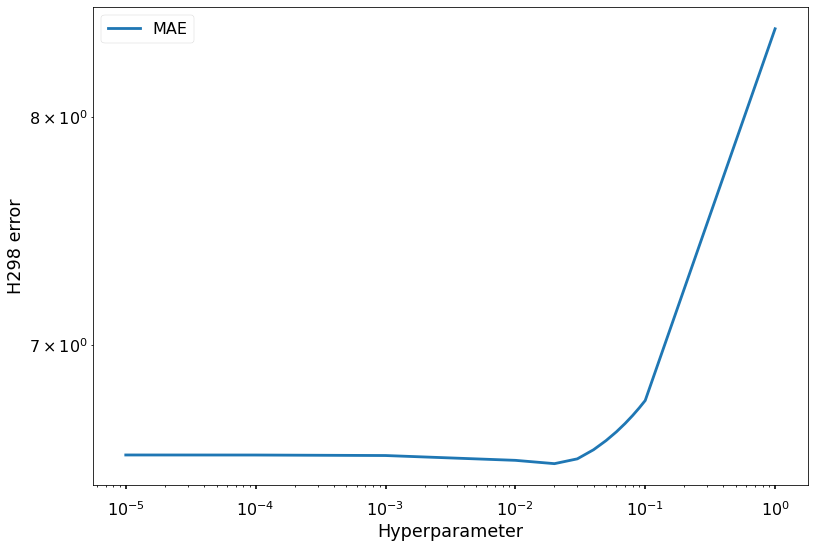

In [332]:
plt.loglog(alphas, RMSEs, label="RMSE")
plt.ylabel("H298 error")
plt.xlabel("Hyperparameter")
plt.legend()
plt.show()
plt.loglog(alphas, MAEs, label="MAE")
print(alphas[np.argmin(MAEs)])
plt.ylabel("H298 error")
plt.xlabel("Hyperparameter")
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

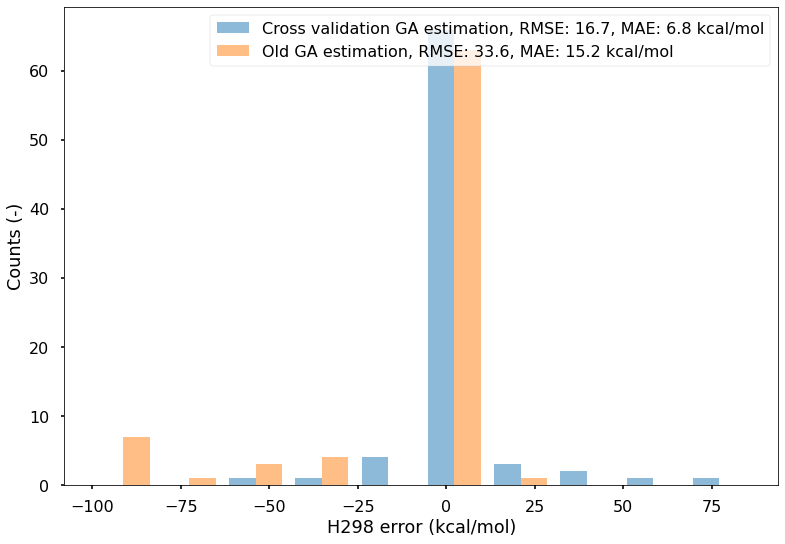

<Figure size 720x720 with 0 Axes>

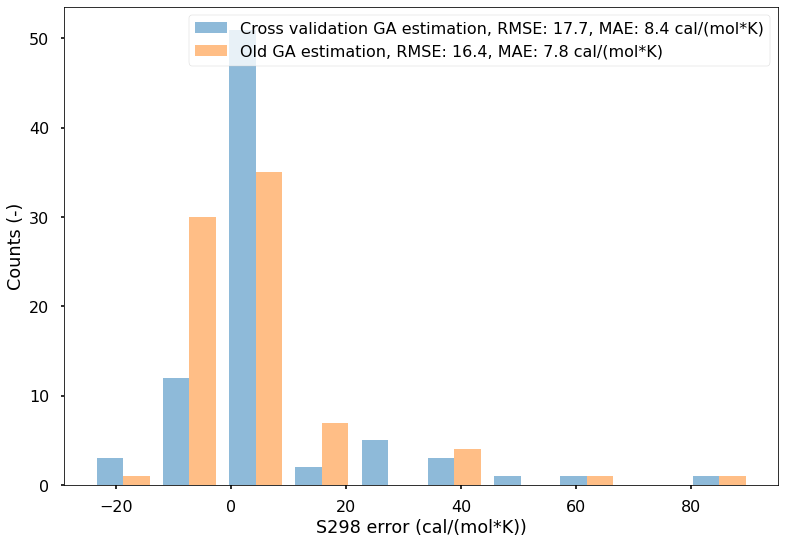

In [333]:
alpha = 0.1
all_data["cross validation estimation"]=list()
for skip_spc_index in range(spc_num):

    A = np.zeros((spc_num,grp_num))
    b = np.zeros((spc_num,9))

    for spc_index, entry in enumerate(all_data["entry"]):
        if spc_index == skip_spc_index:
            pass
        else:
            groups = all_data["missing groups"][spc_index]
            for group in groups:
                A[spc_index, missing_group_index_dict[group]]+=1

            thermo_data = all_data["missing GAE"][spc_index]
            b[spc_index,0] = thermo_data.H298.value_si
            b[spc_index,1] = thermo_data.S298.value_si
            b[spc_index,2:9] = thermo_data.Cpdata.value_si

    soln = Ridge(alpha=alpha,fit_intercept=False,normalize=False, max_iter=1e5).fit(A,b)
    soln_dict["Ridge"]=soln

    b_pred = soln_dict["Ridge"].predict(A)

    standard_error = dict()
    for i in range(b.shape[1]):
        residuals = b[:,i] - b_pred[:,i]
        sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
        var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])))
        standard_error[i] = np.diagonal(var_beta_hat)**0.5

    fitted_group_data = dict()

    for i, label in enumerate(missing_group_index_dict.keys()):
        x = soln_dict["Ridge"].coef_.T
        H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
        H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,9)]
        fitted_group_data[label] = ThermoData(
                Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
                H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
                S298=(S298, "J/(mol*K)", "+|-", S298_unc),
                comment=f"fitted({label})",
            )

    groups = all_data["missing groups"][skip_spc_index]

    GAE_without_estimated_GA = all_data["GAE without estimated GAV"][skip_spc_index]

    fitted_thermo = deepcopy(GAE_without_estimated_GA)
    for group in groups:
        add_thermo_data_unc(fitted_thermo,fitted_group_data[group])

    all_data["cross validation estimation"].append(fitted_thermo)

colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
cross_validation_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    cross_validation_GAE = all_data["cross validation estimation"][spc_index]
    cross_validation_values.append(cross_validation_GAE.H298.value_si/4180)

plt.figure()
RMSE1 = mean_squared_error(entry_values,cross_validation_values,squared=False)
MAE1 = mean_absolute_error(entry_values,cross_validation_values)
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.hist([np.array(entry_values)-np.array(cross_validation_values), np.array(entry_values)-np.array(old_GAE_values)],alpha=0.5,label=[f"Cross validation GA estimation, RMSE: {RMSE1:.1f}, MAE: {MAE1:.1f} kcal/mol",f"Old GA estimation, RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol"])
plt.xlabel("H298 error (kcal/mol)")
plt.ylabel("Counts (-)")
plt.legend()

colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
cross_validation_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    cross_validation_GAE = all_data["cross validation estimation"][spc_index]
    cross_validation_values.append(cross_validation_GAE.S298.value_si/4.180)
    
plt.figure()
RMSE1 = mean_squared_error(entry_values,cross_validation_values,squared=False)
MAE1 = mean_absolute_error(entry_values,cross_validation_values)
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.hist([np.array(entry_values)-np.array(cross_validation_values), np.array(entry_values)-np.array(old_GAE_values)],alpha=0.5,label=[f"Cross validation GA estimation, RMSE: {RMSE1:.1f}, MAE: {MAE1:.1f} cal/(mol*K)", f"Old GA estimation, RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)"])
plt.xlabel("S298 error (cal/(mol*K))")
plt.ylabel("Counts (-)")
plt.legend()

# Save new database to file

In [334]:
database_new.groups["group"].save("/Users/hwpang/Software/RMG-database/input/thermo/groups/group.py")